In [3]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [5]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex

IEX_TOKEN = os.getenv('IEX_TOKEN')
print(IEX_TOKEN)

None


# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [6]:
#list_of_tickers = ["SPY", "AGG"]
#end_date = datetime.now()    
#start_date = end_date - timedelta(days=365)

#spy_data = pd.DataFrame(get_historical_data("SPY", start_date, end_date, close_only=True, token = IEX_TOKEN, infer_datetimeformat = True))
#agg_data = pd.DataFrame(get_historical_data("AGG", start_date, end_date, close_only=True, token = IEX_TOKEN, infer_datetimeformat = True))

#spy_data.to_pickle('spy_data.pickle')
#agg_data.to_pickle('agg_data.pickle')

In [7]:
spy_data = pd.read_pickle('spy_data.pickle')
agg_data = pd.read_pickle('agg_data.pickle')

In [8]:
spy_data_transposed = spy_data.transpose()
spy_data_transposed.columns = ['close','volume']
spy_data_close = spy_data_transposed['close']

agg_data_transposed = agg_data.transpose()
agg_data_transposed.columns = ['close','volume']
agg_data_close = agg_data_transposed['close']

closing_prices = pd.concat([spy_data_close, agg_data_close], axis = 'columns', join = 'inner')
closing_prices.columns = ['SPY Closing Price', 'AGG Closing Price']
closing_prices

,SPY Closing Price,AGG Closing Price
2019-01-29,263.41,106.90
2019-01-30,267.58,107.14
2019-01-31,269.93,107.46
2019-02-01,270.06,106.97
2019-02-04,271.96,106.88
...,...,...
2020-01-22,331.34,113.43
2020-01-23,331.72,113.58
2020-01-24,328.77,113.79
2020-01-27,323.50,114.14


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [9]:
# Calculate the daily roi for the stocks
roi = closing_prices.pct_change()
roi.columns = ['SPY roi', 'AGG roi']
roi

,SPY roi,AGG roi
2019-01-29,NaN,NaN
2019-01-30,0.015831,0.002245
2019-01-31,0.008782,0.002987
2019-02-01,0.000482,-0.004560
2019-02-04,0.007035,-0.000841
...,...,...
2020-01-22,0.000121,0.000529
2020-01-23,0.001147,0.001322
2020-01-24,-0.008893,0.001849
2020-01-27,-0.016029,0.003076


In [10]:
# Calculate volatility
volatility = roi.std()
volatility.index = ['SPY Volatility', 'AGG Volatility']
volatility

SPY Volatility    0.00748
AGG Volatility    0.00209
dtype: float64

In [11]:
agg_average_daily_return = roi['AGG roi'].mean()
spy_average_daily_return = roi['SPY roi'].mean()

In [12]:
# Save the last day's closing price
agg_last_price = closing_prices['AGG Closing Price'][-1]
spy_last_price = closing_prices['SPY Closing Price'][-1]

In [25]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252*30
monte_carlo = pd.DataFrame()

In [26]:
# Run the Monte Carlo Simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

for x in range(number_simulations):

    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    simulated_agg_price = np.random.normal(agg_average_daily_return, volatility['AGG Volatility'], number_records)
    simulated_spy_price = np.random.normal(spy_average_daily_return, volatility['SPY Volatility'], number_records)
    
    for i in range(number_records):
        
        simulated_agg_prices.append(simulated_agg_prices[-1] * (1+ simulated_agg_price[i]))
        simulated_spy_prices.append(simulated_spy_prices[-1] * (1+ simulated_spy_price[i]))
    
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    simulated_daily_returns = simulated_price_df.pct_change()
    
    weights = [0.40, 0.60]

    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997435,0.993923,0.998673,0.998629,1.005252,1.007096,1.004445,0.988694,0.991822,1.001052,...,1.000353,1.003394,1.000420,1.000328,1.001159,1.003134,0.999479,1.004695,1.003531,0.989841
2,0.997731,0.990010,1.005955,1.001221,1.004151,1.001951,1.001599,0.985910,0.990723,1.001604,...,0.997473,1.004883,1.010028,0.997399,1.011806,0.996881,1.006494,1.006345,1.000435,0.998045
3,0.992127,0.984730,1.005752,1.002504,1.004867,0.993149,1.008006,0.984862,0.988788,1.001658,...,0.999316,1.003906,1.006373,0.995372,1.007382,0.998723,1.009458,1.003309,0.996103,0.999706
4,0.992059,0.990573,1.007980,1.002896,1.002234,0.990313,1.005914,0.984734,0.989168,1.002790,...,1.003557,1.002694,1.007945,0.991763,1.004018,0.998966,1.013296,1.008148,0.993509,1.000478


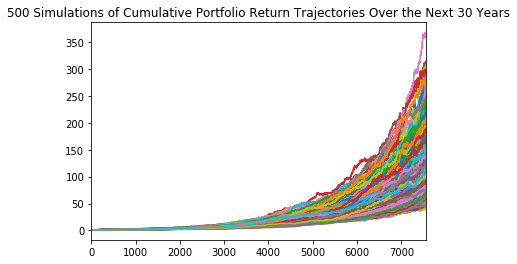

In [27]:
# Visualize the Simulation
plot_title = f"{x+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [28]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
last_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]

In [29]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE

In [30]:
# Display the 90% confidence interval for the ending returns
confidence_interval = last_cumulative_returns.quantile(q=[0.1, 0.9])
confidence_interval

0.1     71.834976
0.9    180.867714
Name: 7560, dtype: float64

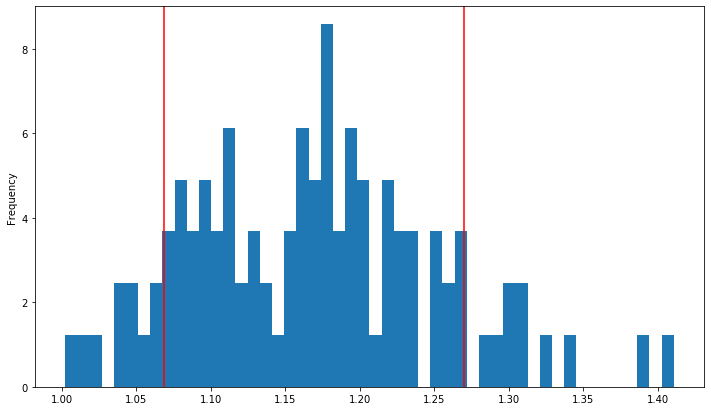

In [20]:
# Visualize the distribution of the ending returns
plt.figure();
last_cumulative_returns.plot(kind='hist', density=True, bins=50,figsize=(12,7))
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [21]:
ten = last_cumulative_returns.quantile(q=.1)
fifty = last_cumulative_returns.quantile(q=.5)
ninety = last_cumulative_returns.quantile(q=.9)
print(f"10th percentile: {ten}")
print(f"50th percentile: {fifty}")
print(f"90th percentile: {ninety}")

10th percentile: 1.0689356753762864
50th percentile: 1.1670210942331423
90th percentile: 1.2701673282358423


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [22]:
initial_investment = 20000
return_ten = initial_investment + (initial_investment * ten)
return_fifty = initial_investment + (initial_investment * fifty)
return_ninety = initial_investment + (initial_investment * ninety)
print(f"10th percentile: {return_ten}")
print(f"50th percentile: {return_fifty}")
print(f"90th percentile: {return_ninety}")

10th percentile: 41378.713507525725
50th percentile: 43340.42188466285
90th percentile: 45403.34656471685


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE